### 1. Setup and Configuration
Imports libraries, defines file paths (updated for Ridge regression), and sets the time window for the full year of 2018.

In [1]:
from pathlib import Path
from typing import List, Tuple

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

import joblib

# -------------------------
# Input
# -------------------------
DATA_PATH = Path("bike_data_clean.parquet")
CLUSTERS_TO_MODEL = [0, 8]

# -------------------------
# Output
# -------------------------
ART_DIR = Path("artifacts_ridge_simple")
PRED_DIR = Path("preds_ridge_simple")
ART_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# Time split
# -------------------------
VAL_START  = pd.to_datetime("2018-11-01")
VAL_END    = pd.to_datetime("2018-12-01")  # exclusive
TEST_START = pd.to_datetime("2018-12-01")  # Dec onward

# Full-year window
START_TIME = pd.Timestamp("2018-01-01 00:00:00")
END_TIME   = pd.Timestamp("2018-12-31 23:00:00")

# Features
NUM_FEATS = ['lag_1','lag_24','lag_168','rmean_3h','rmean_24h']
CAT_FEATS = ['hour','weekday','gmm20_cluster']
FEATURES = NUM_FEATS + CAT_FEATS

EPS = 1e-6

assert DATA_PATH.exists(), f"Missing {DATA_PATH}"
print("[OK] Config set.")
print("[INFO] Window:", START_TIME, "to", END_TIME)
print("[INFO] Val:", VAL_START, "to", VAL_END, "(exclusive)")
print("[INFO] Test from:", TEST_START)

[OK] Config set.
[INFO] Window: 2018-01-01 00:00:00 to 2018-12-31 23:00:00
[INFO] Val: 2018-11-01 00:00:00 to 2018-12-01 00:00:00 (exclusive)
[INFO] Test from: 2018-12-01 00:00:00


### 2. Data Aggregation
Aggregates raw trip data into hourly time series (pickups and dropoffs) for the specified clusters.

In [2]:
def build_hourly_series_for_clusters(
    df: pd.DataFrame,
    clusters: List[int],
    start_time: pd.Timestamp,
    end_time: pd.Timestamp,
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    clusters = [int(c) for c in clusters]
    clusters_set = set(clusters)

    needed_cols = ["gmm20_cluster","end_gmm20_cluster","start_date","start_hour","stop_date","stop_hour"]
    missing = [c for c in needed_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in df: {missing}")

    start_ts = pd.to_datetime(df["start_date"]).dt.normalize() + pd.to_timedelta(df["start_hour"], unit="h")
    stop_ts  = pd.to_datetime(df["stop_date"]).dt.normalize()  + pd.to_timedelta(df["stop_hour"], unit="h")

    pick_mask = df["gmm20_cluster"].isin(clusters_set)
    pick_tbl = pd.DataFrame({
        "gmm20_cluster": df.loc[pick_mask, "gmm20_cluster"].astype("int16").values,
        "timestamp": pd.to_datetime(start_ts.loc[pick_mask]).dt.floor("H").values
    })
    pick_tbl = pick_tbl[(pick_tbl["timestamp"] >= start_time) & (pick_tbl["timestamp"] <= end_time)]
    agg_pick = pick_tbl.groupby(["gmm20_cluster","timestamp"]).size().rename("pickups").reset_index()

    drop_mask = df["end_gmm20_cluster"].isin(clusters_set)
    drop_tbl = pd.DataFrame({
        "gmm20_cluster": df.loc[drop_mask, "end_gmm20_cluster"].astype("int16").values,
        "timestamp": pd.to_datetime(stop_ts.loc[drop_mask]).dt.floor("H").values
    })
    drop_tbl = drop_tbl[(drop_tbl["timestamp"] >= start_time) & (drop_tbl["timestamp"] <= end_time)]
    agg_drop = drop_tbl.groupby(["gmm20_cluster","timestamp"]).size().rename("dropoffs").reset_index()

    hours = pd.date_range(start_time, end_time, freq="H")
    grid = pd.MultiIndex.from_product([clusters, hours], names=["gmm20_cluster","timestamp"]).to_frame(index=False)

    ts_pick = grid.merge(agg_pick, on=["gmm20_cluster","timestamp"], how="left")
    ts_pick["pickups"] = ts_pick["pickups"].fillna(0).astype("float32")

    ts_drop = grid.merge(agg_drop, on=["gmm20_cluster","timestamp"], how="left")
    ts_drop["dropoffs"] = ts_drop["dropoffs"].fillna(0).astype("float32")

    return ts_pick, ts_drop

### 3. Feature Engineering
Generates lag features (1h, 24h, 1 week) and rolling means to capture temporal dependencies.

In [3]:
def add_lags_rolls(df_in: pd.DataFrame, value_col: str, lags=(1, 24, 168)) -> pd.DataFrame:
    df = df_in.sort_values(["gmm20_cluster", "timestamp"]).copy()
    g = df.groupby("gmm20_cluster")[value_col]

    for lag in lags:
        df[f"lag_{lag}"] = g.shift(lag)

    shifted = g.shift(1)
    df["rmean_3h"]  = shifted.groupby(df["gmm20_cluster"]).rolling(3,  min_periods=3).mean().reset_index(level=0, drop=True)
    df["rmean_24h"] = shifted.groupby(df["gmm20_cluster"]).rolling(24, min_periods=24).mean().reset_index(level=0, drop=True)

    df["hour"] = df["timestamp"].dt.hour.astype("int8")
    df["weekday"] = df["timestamp"].dt.weekday.astype("int8")

    df["y"] = df[value_col].astype("float32")
    return df

def make_feature_table(ts_pick: pd.DataFrame, ts_drop: pd.DataFrame):
    pick_feat = add_lags_rolls(ts_pick, "pickups").dropna().reset_index(drop=True)
    drop_feat = add_lags_rolls(ts_drop, "dropoffs").dropna().reset_index(drop=True)

    keep = ["timestamp"] + FEATURES + ["y"]
    return pick_feat[keep].copy(), drop_feat[keep].copy()

### 4. Data Splitting
Splits the time series data into Train (Jan-Oct), Validation (Nov), and Test (Dec) sets.

In [4]:
def split_blocks(ts: pd.DataFrame):
    train = ts[ts["timestamp"] < VAL_START].copy()
    val   = ts[(ts["timestamp"] >= VAL_START) & (ts["timestamp"] < VAL_END)].copy()
    test  = ts[ts["timestamp"] >= TEST_START].copy()
    return train, val, test

### 5. Model Architecture
Defines the Ridge Regression pipeline, utilizing One-Hot Encoding for categorical features and passing through numeric features.

In [5]:
def make_ohe():
    # sklearn compatibility across versions
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

def make_preprocessor():
    return ColumnTransformer(
        transformers=[
            ("cat", make_ohe(), CAT_FEATS),
            ("num", "passthrough", NUM_FEATS),
        ],
        remainder="drop",
        sparse_threshold=1.0,
    )

def make_ridge():
    """
    Defines a Ridge regression model. 
    Ridge is chosen as a robust linear baseline that handles the multicollinearity 
    introduced by One-Hot Encoding (OHE) better than standard LinearRegression.
    """
    return Ridge(
        alpha=1.0,
        fit_intercept=True,
        solver="auto",
    )

def fit_ridge(train_df: pd.DataFrame):
    pre = make_preprocessor()
    Xtr = pre.fit_transform(train_df[FEATURES])
    ytr = train_df["y"].values.astype("float32")
    model = make_ridge()
    model.fit(Xtr, ytr)
    return pre, model

def predict_ridge_nonneg(pre, model, df: pd.DataFrame) -> np.ndarray:
    X = pre.transform(df[FEATURES])
    pred = model.predict(X).astype("float32")
    return np.clip(pred, 0.0, None)

### 6. Output Formatting
Helper function to merge model predictions with ground truth data, ensuring consistent column naming for the Ridge model.

In [6]:
def to_output_df(
    cluster_id: int,
    split_name: str,
    block_pick: pd.DataFrame,
    block_drop: pd.DataFrame,
    pred_pick: np.ndarray,
    pred_drop: np.ndarray,
) -> pd.DataFrame:
    a = block_pick[["timestamp", "hour", "y"]].rename(columns={"y": "y_true_pickups"})
    b = block_drop[["timestamp", "hour", "y"]].rename(columns={"y": "y_true_dropoffs"})
    out = a.merge(b, on=["timestamp", "hour"], how="inner")

    out["y_pred_ridge_pickups"] = pred_pick[:len(out)]
    out["y_pred_ridge_dropoffs"] = pred_drop[:len(out)]

    out["date"] = pd.to_datetime(out["timestamp"]).dt.normalize()
    out["cluster_id"] = int(cluster_id)
    out["split"] = split_name

    return out[[
        "date","hour","cluster_id","split",
        "y_true_pickups","y_pred_ridge_pickups",
        "y_true_dropoffs","y_pred_ridge_dropoffs",
    ]]

### 7. Training and Execution Loop
Iterates through each cluster to train Ridge models for pickups and dropoffs, saving predictions and artifacts.

In [7]:
needed_cols = ["gmm20_cluster","end_gmm20_cluster","start_date","start_hour","stop_date","stop_hour"]
df = pd.read_parquet(DATA_PATH, columns=needed_cols)
print("[INFO] Loaded df:", df.shape)

clusters_set = set(CLUSTERS_TO_MODEL)
mask = df["gmm20_cluster"].isin(clusters_set) | df["end_gmm20_cluster"].isin(clusters_set)
df = df.loc[mask].copy()
print("[INFO] Filtered df:", df.shape)

ts_pick, ts_drop = build_hourly_series_for_clusters(df, CLUSTERS_TO_MODEL, START_TIME, END_TIME)
pick_feat_all, drop_feat_all = make_feature_table(ts_pick, ts_drop)
print("[INFO] pick_feat_all:", pick_feat_all.shape, "drop_feat_all:", drop_feat_all.shape)

all_out_rows = []

for cid in CLUSTERS_TO_MODEL:
    print("\n" + "="*80)
    print(f"[CLUSTER {cid}] training simple Ridge...")

    pick_c = pick_feat_all[pick_feat_all["gmm20_cluster"] == cid].copy()
    drop_c = drop_feat_all[drop_feat_all["gmm20_cluster"] == cid].copy()

    tr_p, va_p, te_p = split_blocks(pick_c)
    tr_d, va_d, te_d = split_blocks(drop_c)

    print(f"[CLUSTER {cid}] train/val/test sizes (pick) = {len(tr_p)}/{len(va_p)}/{len(te_p)}")
    print(f"[CLUSTER {cid}] train/val/test sizes (drop) = {len(tr_d)}/{len(va_d)}/{len(te_d)}")

    # fit pickups
    pre_p, model_p = fit_ridge(tr_p)
    pred_val_p  = predict_ridge_nonneg(pre_p, model_p, va_p)
    pred_test_p = predict_ridge_nonneg(pre_p, model_p, te_p) if len(te_p) else np.array([], dtype="float32")

    # fit dropoffs
    pre_d, model_d = fit_ridge(tr_d)
    pred_val_d  = predict_ridge_nonneg(pre_d, model_d, va_d)
    pred_test_d = predict_ridge_nonneg(pre_d, model_d, te_d) if len(te_d) else np.array([], dtype="float32")

    df_val_out = to_output_df(cid, "val", va_p, va_d, pred_val_p, pred_val_d)
    all_out_rows.append(df_val_out)

    if len(te_p) and len(te_d):
        df_test_out = to_output_df(cid, "test", te_p, te_d, pred_test_p, pred_test_d)
        all_out_rows.append(df_test_out)

    # Save predictions per cluster
    df_out = pd.concat([df_val_out] + ([df_test_out] if len(te_p) and len(te_d) else []), ignore_index=True)
    out_path = PRED_DIR / f"ridge_cluster_{cid}_preds.parquet"
    df_out.to_parquet(out_path, index=False)
    print(f"[CLUSTER {cid}] saved predictions -> {out_path}")

    # Save artifacts (simple)
    artifact = {
        "cluster_id": int(cid),
        "pre_pickups": pre_p,
        "model_pickups": model_p,
        "pre_dropoffs": pre_d,
        "model_dropoffs": model_d,
        "features": FEATURES,
        "num_feats": NUM_FEATS,
        "cat_feats": CAT_FEATS,
        "split_info": {
            "start_time": str(START_TIME),
            "val_start": str(VAL_START),
            "val_end_exclusive": str(VAL_END),
            "test_start": str(TEST_START),
            "end_time": str(END_TIME),
        }
    }
    art_path = ART_DIR / f"ridge_cluster_{cid}.joblib"
    joblib.dump(artifact, art_path)
    print(f"[CLUSTER {cid}] saved artifact -> {art_path}")

print("\n[OK] Finished all clusters.")

[INFO] Loaded df: (17531179, 6)
[INFO] Filtered df: (3935878, 6)


C:\Users\andre\AppData\Local\Temp\ipykernel_3012\1292131563.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "timestamp": pd.to_datetime(start_ts.loc[pick_mask]).dt.floor("H").values
C:\Users\andre\AppData\Local\Temp\ipykernel_3012\1292131563.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "timestamp": pd.to_datetime(stop_ts.loc[drop_mask]).dt.floor("H").values
C:\Users\andre\AppData\Local\Temp\ipykernel_3012\1292131563.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start_time, end_time, freq="H")


[INFO] pick_feat_all: (17184, 10) drop_feat_all: (17184, 10)

[CLUSTER 0] training simple Ridge...
[CLUSTER 0] train/val/test sizes (pick) = 7128/720/744
[CLUSTER 0] train/val/test sizes (drop) = 7128/720/744
[CLUSTER 0] saved predictions -> preds_ridge_simple\ridge_cluster_0_preds.parquet
[CLUSTER 0] saved artifact -> artifacts_ridge_simple\ridge_cluster_0.joblib

[CLUSTER 8] training simple Ridge...
[CLUSTER 8] train/val/test sizes (pick) = 7128/720/744
[CLUSTER 8] train/val/test sizes (drop) = 7128/720/744
[CLUSTER 8] saved predictions -> preds_ridge_simple\ridge_cluster_8_preds.parquet
[CLUSTER 8] saved artifact -> artifacts_ridge_simple\ridge_cluster_8.joblib

[OK] Finished all clusters.


### 8. Global Evaluation and Weighting
Calculates the RMSE for the test period (December) and computes the ensemble weight for the Ridge model.

In [8]:
out_all = pd.concat(all_out_rows, ignore_index=True)

test_all = out_all[out_all["split"] == "test"].copy()
assert len(test_all), "No test rows found (expected December). Check END_TIME / TEST_START."

rmse_pick_test = float(np.sqrt(mean_squared_error(test_all["y_true_pickups"], test_all["y_pred_ridge_pickups"])))
rmse_drop_test = float(np.sqrt(mean_squared_error(test_all["y_true_dropoffs"], test_all["y_pred_ridge_dropoffs"])))
rmse_mean_test = 0.5 * (rmse_pick_test + rmse_drop_test)

# Baseline lag_24 in the output space (per cluster)
test_all_sorted = test_all.sort_values(["cluster_id", "date", "hour"]).copy()
test_all_sorted["baseline_pick"] = test_all_sorted.groupby("cluster_id")["y_true_pickups"].shift(24)
test_all_sorted["baseline_drop"] = test_all_sorted.groupby("cluster_id")["y_true_dropoffs"].shift(24)
base_ok = test_all_sorted.dropna(subset=["baseline_pick","baseline_drop"])

rmse_pick_base = float(np.sqrt(mean_squared_error(base_ok["y_true_pickups"], base_ok["baseline_pick"])))
rmse_drop_base = float(np.sqrt(mean_squared_error(base_ok["y_true_dropoffs"], base_ok["baseline_drop"])))
rmse_mean_base = 0.5 * (rmse_pick_base + rmse_drop_base)

general_weight_raw = 1.0 / (rmse_mean_test + EPS)

weight_payload = {
    "model": "ridge_hourly_ridge_features_simple",
    "clusters": CLUSTERS_TO_MODEL,
    "test_period": {"start_inclusive": str(TEST_START.date()), "end_inclusive": str(END_TIME.date())},
    "rmse_pickups_test": rmse_pick_test,
    "rmse_dropoffs_test": rmse_drop_test,
    "general_rmse_test": rmse_mean_test,
    "rmse_pickups_baseline_lag24_test": rmse_pick_base,
    "rmse_dropoffs_baseline_lag24_test": rmse_drop_base,
    "general_rmse_baseline_lag24_test": rmse_mean_base,
    "general_weight_raw": general_weight_raw,
    "notes": "Ridge regression on raw counts (with OHE+numeric features). Test RMSE is December."
}

weight_path = ART_DIR / "ridge_general_weight_test_december.json"
weight_path.write_text(json.dumps(weight_payload, indent=2))
print("[OK] Saved:", weight_path)
print(json.dumps(weight_payload, indent=2))

[OK] Saved: artifacts_ridge_simple\ridge_general_weight_test_december.json
{
  "model": "ridge_hourly_ridge_features_simple",
  "clusters": [
    0,
    8
  ],
  "test_period": {
    "start_inclusive": "2018-12-01",
    "end_inclusive": "2018-12-31"
  },
  "rmse_pickups_test": 49.964805603027344,
  "rmse_dropoffs_test": 42.29716491699219,
  "general_rmse_test": 46.130985260009766,
  "rmse_pickups_baseline_lag24_test": 88.60916900634766,
  "rmse_dropoffs_baseline_lag24_test": 83.24129486083984,
  "general_rmse_baseline_lag24_test": 85.92523193359375,
  "general_weight_raw": 0.02167740343472527,
  "notes": "Ridge regression on raw counts (with OHE+numeric features). Test RMSE is December."
}


### 9. Analysis Helper Functions
Utilities for loading cluster outputs and calculating the "Required Bikes" metric based on net flow.

In [9]:
def rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

def load_all_cluster_outputs(clusters, pred_dir: Path):
    dfs = []
    for cid in clusters:
        p = pred_dir / f"ridge_cluster_{cid}_preds.parquet"
        dfs.append(pd.read_parquet(p))
    out = pd.concat(dfs, ignore_index=True)
    out["timestamp"] = pd.to_datetime(out["date"]) + pd.to_timedelta(out["hour"], unit="h")
    out["month"] = out["timestamp"].dt.to_period("M").astype(str)
    return out

def compute_required_bikes_series(Yp: np.ndarray, Yd: np.ndarray) -> np.ndarray:
    required = []
    for pickups, dropoffs in zip(Yp, Yd):
        net = dropoffs - pickups
        cum_net = np.cumsum(net)
        min_cum = float(cum_net.min())
        req = max(0.0, -min_cum)
        required.append(req)
    return np.array(required, dtype="float32")

def daily_required_from_hourly_df(df_hourly: pd.DataFrame, true_col_p, true_col_d, pred_col_p, pred_col_d):
    dfh = df_hourly.copy()
    dfh["day"] = dfh["timestamp"].dt.normalize()

    days = []
    for day, g in dfh.groupby("day"):
        g = g.sort_values("hour")
        if len(g) < 24:
            continue
        Yp_true = g[true_col_p].values.reshape(1, -1)
        Yd_true = g[true_col_d].values.reshape(1, -1)
        Yp_pred = g[pred_col_p].values.reshape(1, -1)
        Yd_pred = g[pred_col_d].values.reshape(1, -1)

        req_true = compute_required_bikes_series(Yp_true, Yd_true)[0]
        req_pred = compute_required_bikes_series(Yp_pred, Yd_pred)[0]
        days.append((day, req_true, req_pred))

    return pd.DataFrame(days, columns=["day", "required_true", "required_pred"])

### 10. Performance Dashboard
Visualizes Ridge model performance, including weekly predictions, required bike estimates, and daily RMSE metrics.

C:\Users\andre\AppData\Local\Temp\ipykernel_3012\3110034374.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


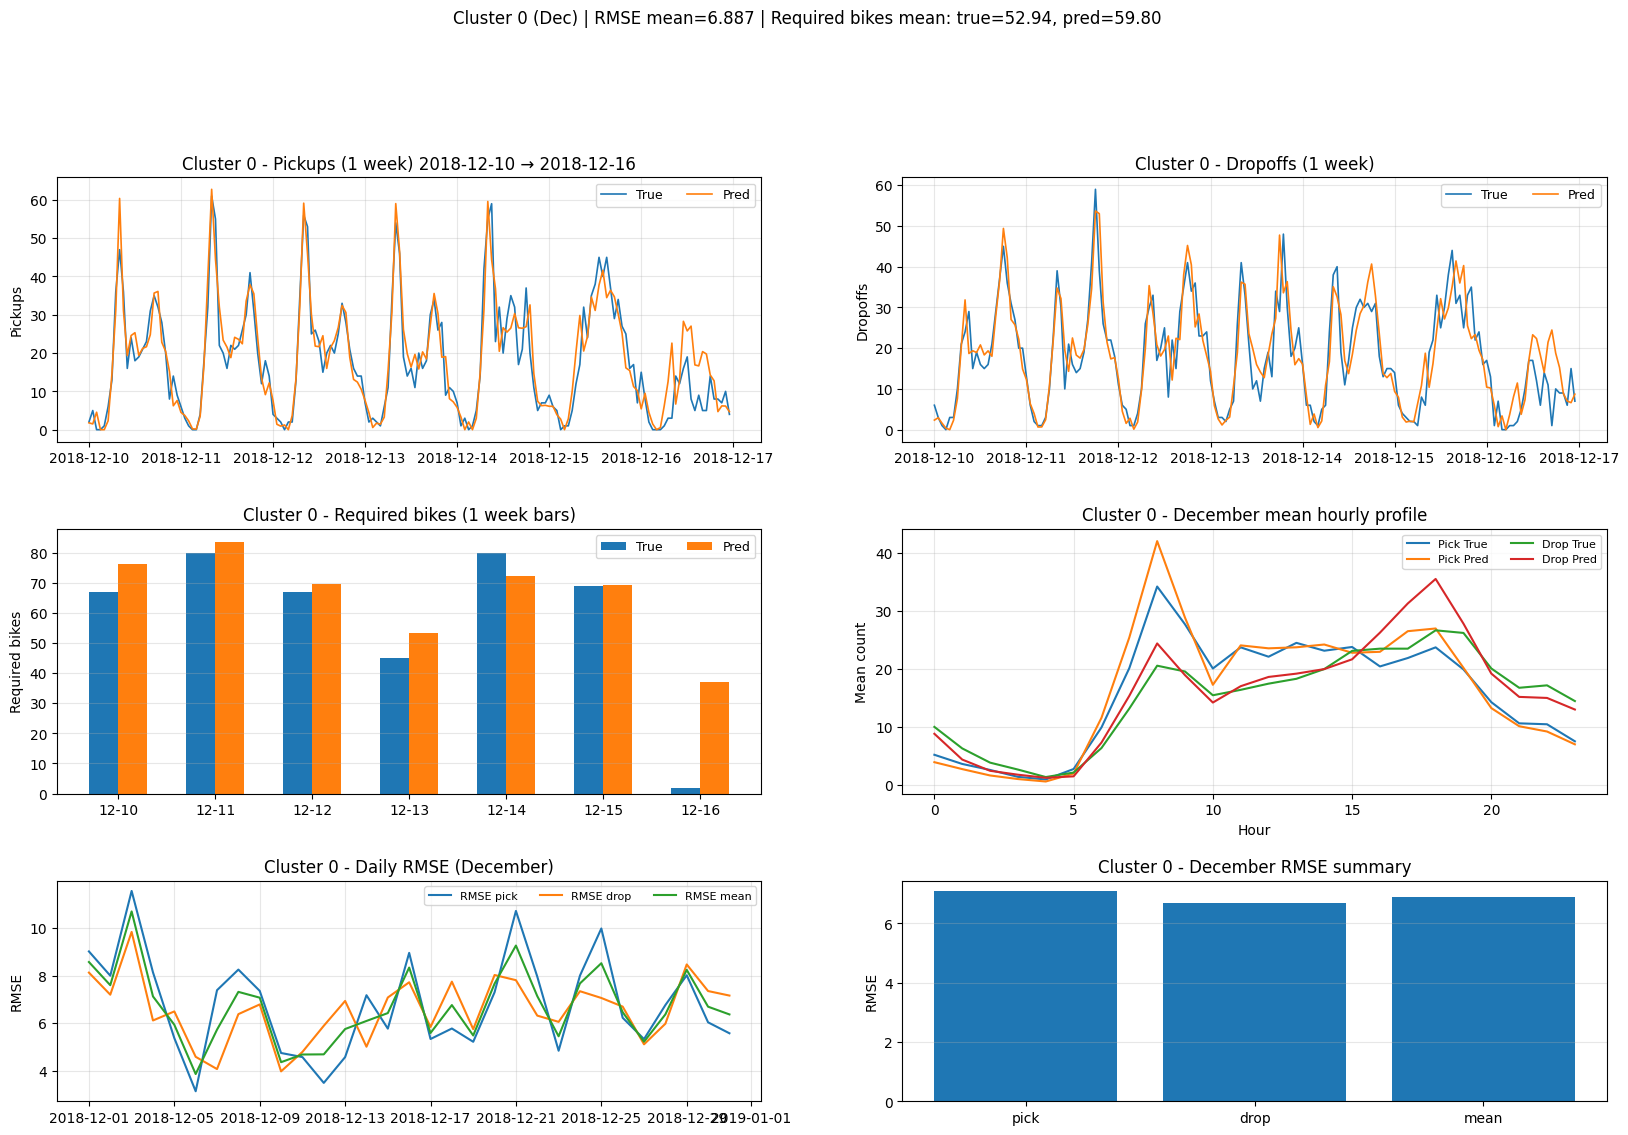

C:\Users\andre\AppData\Local\Temp\ipykernel_3012\3110034374.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


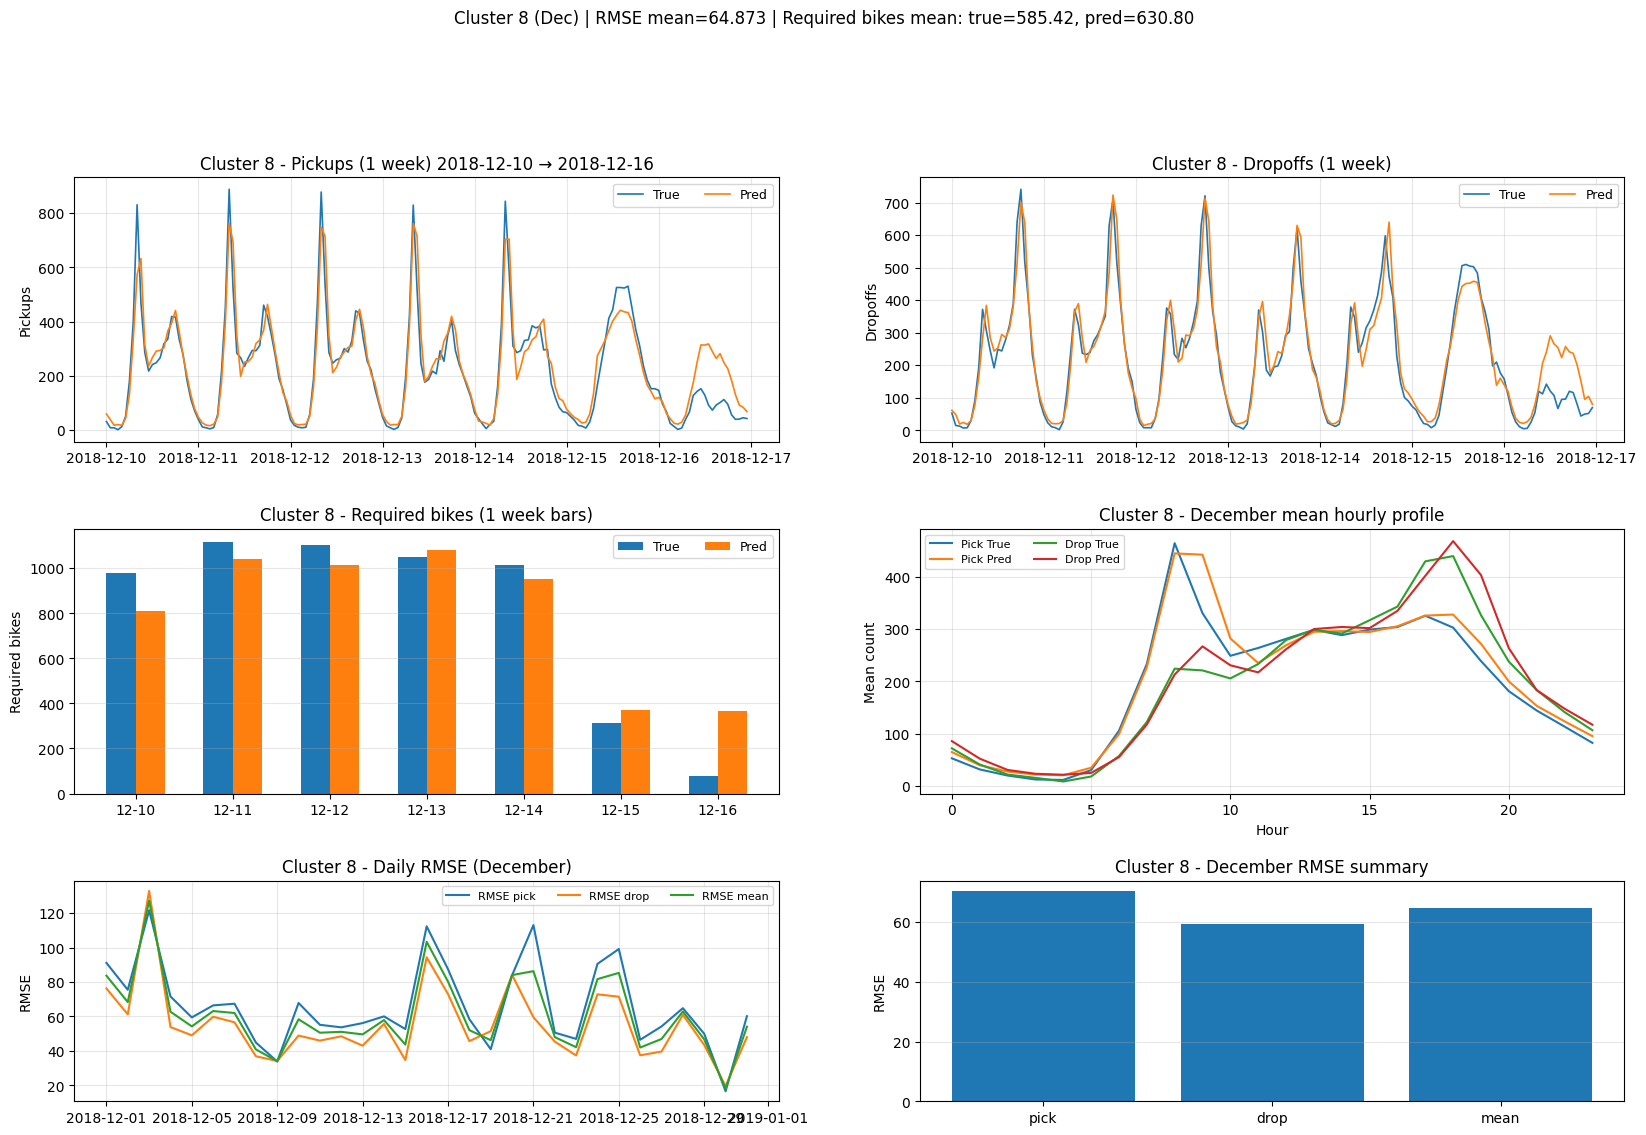

In [10]:
out_all = load_all_cluster_outputs(CLUSTERS_TO_MODEL, PRED_DIR)

DEC_START = pd.Timestamp("2018-12-01")
DEC_END   = pd.Timestamp("2018-12-31 23:00:00")

WEEK_START = pd.Timestamp("2018-12-10 00:00:00")
WEEK_END   = WEEK_START + pd.Timedelta(days=7)  # exclusive

TRUE_P = "y_true_pickups"
PRED_P = "y_pred_ridge_pickups"
TRUE_D = "y_true_dropoffs"
PRED_D = "y_pred_ridge_dropoffs"

for cid in CLUSTERS_TO_MODEL:
    dfc = out_all[(out_all["cluster_id"] == cid) & (out_all["split"] == "test")].copy()
    dfc = dfc[(dfc["timestamp"] >= DEC_START) & (dfc["timestamp"] <= DEC_END)]
    dfc = dfc.sort_values("timestamp")

    if dfc.empty:
        print(f"[WARN] No December test data for cluster {cid}")
        continue

    week = dfc[(dfc["timestamp"] >= WEEK_START) & (dfc["timestamp"] < WEEK_END)].copy()

    mean_hour = (
        dfc.groupby("hour")[[TRUE_P, PRED_P, TRUE_D, PRED_D]]
        .mean()
        .reset_index()
        .sort_values("hour")
    )

    req_daily = daily_required_from_hourly_df(dfc, TRUE_P, TRUE_D, PRED_P, PRED_D)
    mean_req = req_daily[["required_true", "required_pred"]].mean()

    dfc["day"] = dfc["timestamp"].dt.normalize()
    daily_metrics = []
    for day, g in dfc.groupby("day"):
        g = g.sort_values("hour")
        if len(g) < 24:
            continue
        rp = rmse(g[TRUE_P].values, g[PRED_P].values)
        rd = rmse(g[TRUE_D].values, g[PRED_D].values)
        daily_metrics.append((day, rp, rd, 0.5*(rp+rd)))
    daily_metrics = pd.DataFrame(daily_metrics, columns=["day", "rmse_pickups", "rmse_dropoffs", "rmse_mean"])

    rmse_pick = rmse(dfc[TRUE_P].values, dfc[PRED_P].values)
    rmse_drop = rmse(dfc[TRUE_D].values, dfc[PRED_D].values)
    rmse_avg  = 0.5*(rmse_pick + rmse_drop)

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1.2, 1.0], hspace=0.35, wspace=0.2)

    # (1) One-week pickups
    ax = fig.add_subplot(gs[0, 0])
    if not week.empty:
        ax.plot(week["timestamp"], week[TRUE_P], label="True", linewidth=1.2)
        ax.plot(week["timestamp"], week[PRED_P], label="Pred", linewidth=1.2)
        ax.set_title(f"Cluster {cid} - Pickups (1 week) {WEEK_START.date()} → {(WEEK_END - pd.Timedelta(hours=1)).date()}")
        ax.set_ylabel("Pickups")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=2, fontsize=9)
    else:
        ax.text(0.5, 0.5, "Week window empty", ha="center", va="center")
        ax.set_axis_off()

    # (2) One-week dropoffs
    ax = fig.add_subplot(gs[0, 1])
    if not week.empty:
        ax.plot(week["timestamp"], week[TRUE_D], label="True", linewidth=1.2)
        ax.plot(week["timestamp"], week[PRED_D], label="Pred", linewidth=1.2)
        ax.set_title(f"Cluster {cid} - Dropoffs (1 week)")
        ax.set_ylabel("Dropoffs")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=2, fontsize=9)
    else:
        ax.text(0.5, 0.5, "Week window empty", ha="center", va="center")
        ax.set_axis_off()

    # (3) Required bikes bars (first 7 days of the week)
    ax = fig.add_subplot(gs[1, 0])
    if not week.empty:
        req_week = daily_required_from_hourly_df(week, TRUE_P, TRUE_D, PRED_P, PRED_D)
        req_week = req_week.sort_values("day").head(7)
        x = np.arange(len(req_week))
        ax.bar(x - 0.15, req_week["required_true"].values, width=0.3, label="True")
        ax.bar(x + 0.15, req_week["required_pred"].values, width=0.3, label="Pred")
        ax.set_xticks(x)
        ax.set_xticklabels(req_week["day"].dt.strftime("%m-%d").values, rotation=0)
        ax.set_title(f"Cluster {cid} - Required bikes (1 week bars)")
        ax.set_ylabel("Required bikes")
        ax.legend(ncol=2, fontsize=9)
        ax.grid(True, axis="y", alpha=0.3)
    else:
        ax.text(0.5, 0.5, "Week window empty", ha="center", va="center")
        ax.set_axis_off()

    # (4) December mean hourly profile
    ax = fig.add_subplot(gs[1, 1])
    ax.plot(mean_hour["hour"], mean_hour[TRUE_P], label="Pick True")
    ax.plot(mean_hour["hour"], mean_hour[PRED_P], label="Pick Pred")
    ax.plot(mean_hour["hour"], mean_hour[TRUE_D], label="Drop True")
    ax.plot(mean_hour["hour"], mean_hour[PRED_D], label="Drop Pred")
    ax.set_title(f"Cluster {cid} - December mean hourly profile")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Mean count")
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=8)

    # (5) Daily RMSE line
    ax = fig.add_subplot(gs[2, 0])
    if not daily_metrics.empty:
        ax.plot(daily_metrics["day"], daily_metrics["rmse_pickups"], label="RMSE pick")
        ax.plot(daily_metrics["day"], daily_metrics["rmse_dropoffs"], label="RMSE drop")
        ax.plot(daily_metrics["day"], daily_metrics["rmse_mean"], label="RMSE mean")
        ax.set_title(f"Cluster {cid} - Daily RMSE (December)")
        ax.set_ylabel("RMSE")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=3, fontsize=8)
    else:
        ax.text(0.5, 0.5, "No daily metrics", ha="center", va="center")
        ax.set_axis_off()

    # (6) RMSE summary bars
    ax = fig.add_subplot(gs[2, 1])
    ax.bar(["pick", "drop", "mean"], [rmse_pick, rmse_drop, rmse_avg])
    ax.set_title(f"Cluster {cid} - December RMSE summary")
    ax.set_ylabel("RMSE")
    ax.grid(True, axis="y", alpha=0.3)

    fig.suptitle(
        f"Cluster {cid} (Dec) | RMSE mean={rmse_avg:.3f} | Required bikes mean: true={mean_req['required_true']:.2f}, pred={mean_req['required_pred']:.2f}",
        y=1.02,
        fontsize=12
    )

    plt.tight_layout()
    plt.show()